In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import zipfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset path
zip_path = '/content/drive/MyDrive/teeth.zip'
base_dir = '/content/dental-xray'

# Unzip dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

print("Dataset extracted to", base_dir)

# Define dataset directories
train_dir = os.path.join(base_dir, 'Segmented Dental Radiography', 'train')
val_dir = os.path.join(base_dir, 'Segmented Dental Radiography', 'valid')
test_dir = os.path.join(base_dir, 'Segmented Dental Radiography', 'test')

# Image parameters
img_height, img_width = 128, 128
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical'
)

# Important: Make sure `shuffle=False` and correct batch size for prediction
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

# Compute class weights
labels = train_generator.classes
class_weights_arr = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y = labels)
class_weights = dict(enumerate(class_weights_arr))
print("Class Weights:", class_weights)

# Define focal loss
def focal_loss(gamma = 2., alpha = 0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = tf.reduce_sum(weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Load base model
base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (img_height, img_width, 3))
base_model.trainable = False

# Build the full model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(train_generator.num_classes, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = output)

# Compile the model
model.compile(optimizer = 'adam',
              loss=focal_loss(gamma = 2., alpha = 0.25),
              metrics=['accuracy'])

# Train the model
epochs = 15
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs,
    class_weight = class_weights
)

# Predict on test data
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = np.argmax(pred_probs, axis = 1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, pred_classes, target_names = class_labels, output_dict = True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("dental_classification_report_focal.csv")

print("Classification report saved as 'dental_classification_report_focal.csv'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/dental-xray
Found 25410 images belonging to 5 classes.
Found 2721 images belonging to 5 classes.
Found 1714 images belonging to 5 classes.
Class Weights: {0: np.float64(8.822916666666666), 1: np.float64(0.9694772987409386), 2: np.float64(11.873831775700934), 3: np.float64(2.848654708520179), 4: np.float64(0.29240506329113924)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 519s 643ms/step - accuracy: 0.7263 - loss: 0.1149 - val_accuracy: 0.7986 - val_loss: 0.0576
Epoch 2/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 473s 595ms/step - accuracy: 0.7837 - loss: 0.0741 - val_accuracy: 0.8207 - val_loss: 0.0522
Epoch 3/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 498s 627ms/step - accuracy: 0.8046 - loss: 0.0642 - val_accuracy: 0.8225 - val_loss: 0.0512
Epoch 4/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 492s 619ms/step - accuracy: 0.8057 - loss: 0.0601 - val_accuracy: 0.8082 - val_loss: 0.0554
Epoch 5/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 494s 622ms/step - accuracy: 0.8086 - loss: 0.0597 - val_accuracy: 0.8148 - val_loss: 0.0615
Epoch 6/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 496s 623ms/step - accuracy: 0.8152 - loss: 0.0573 - val_accuracy: 0.8331 - val_loss: 0.0470
Epoch 7/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 489s 615ms/step - accuracy: 0.8200 - loss: 0.0553 - val_accuracy: 0.8273 - val_loss: 0.0512
Epoch 8/15
795/795 ━━━━━━━━━━━━━━━━━━━━ 492s 619ms/step - accuracy: 0.8165 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-6-8338c11d1c35>:19: FutureWarning:

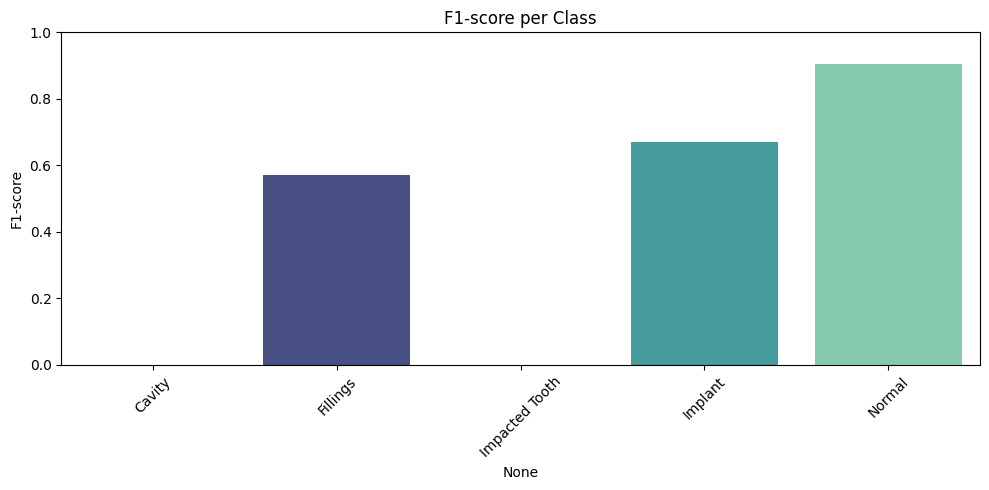

<ipython-input-6-8338c11d1c35>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = class_rows.index, y = 'precision', data = class_rows, palette = 'crest')


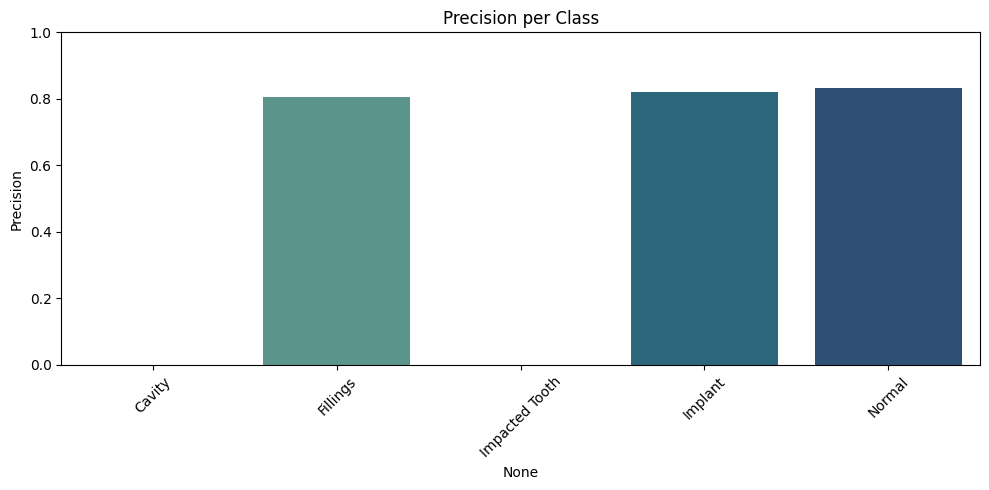

<ipython-input-6-8338c11d1c35>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = class_rows.index, y = 'recall', data = class_rows, palette = 'flare')


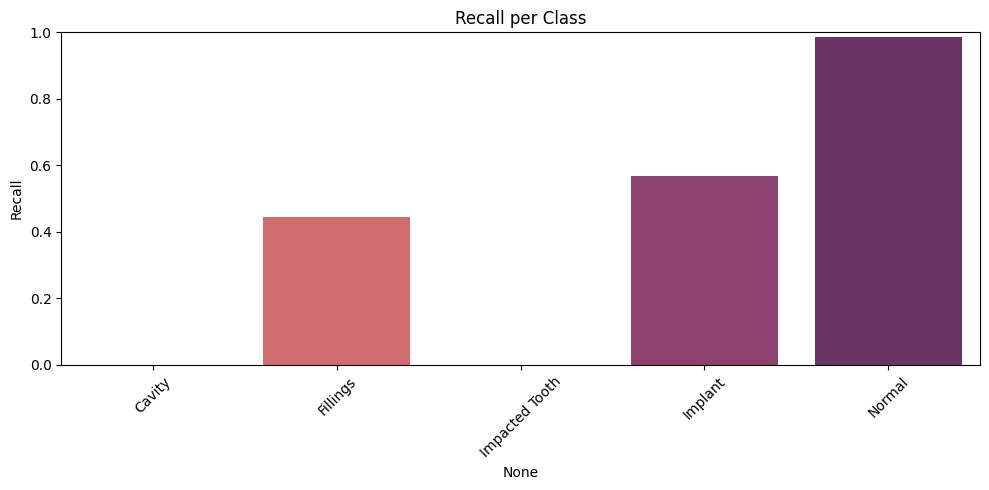

<ipython-input-6-8338c11d1c35>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_rows.index, y = 'support', data = class_rows, palette = 'viridis')


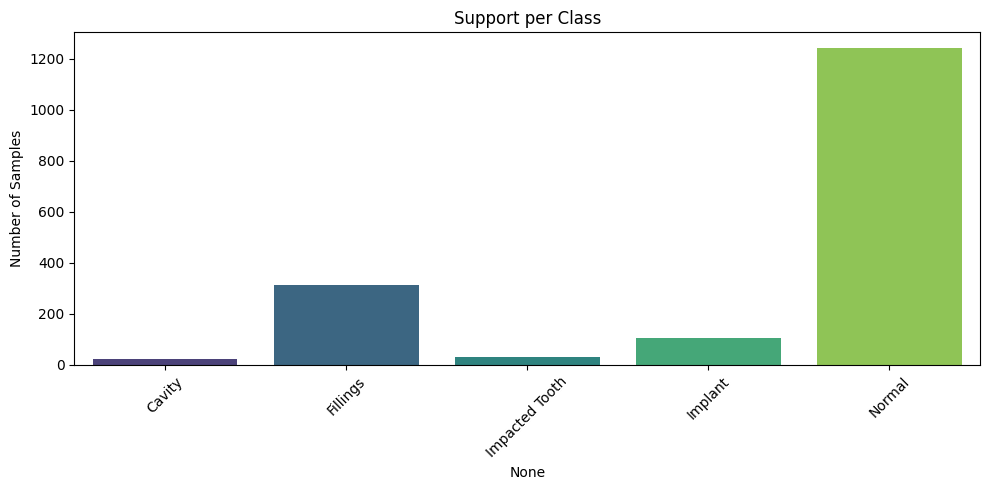

<Figure size 800x600 with 0 Axes>

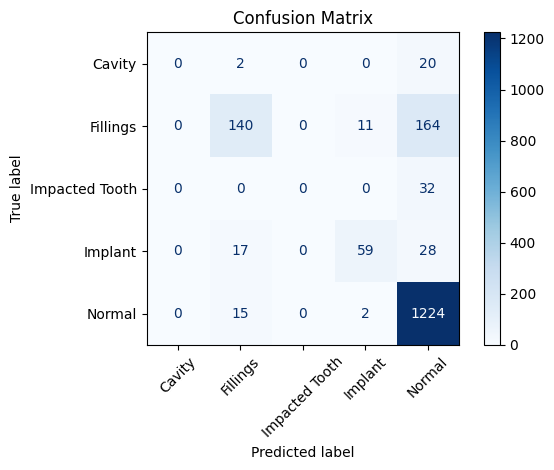

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CLASSIFICATION REPORT
report = classification_report(true_classes, pred_classes, target_names = class_labels, output_dict = True)
report_df = pd.DataFrame(report).transpose()

# Save to CSV
report_df.to_csv("dental_classification_report.csv")

# Exclude last 3 rows for per-class plotting
class_rows = report_df.iloc[:-3]

# Plot F1-score
plt.figure(figsize = (10, 5))
sns.barplot(x = class_rows.index, y = 'f1-score', data = class_rows, palette = 'mako')
plt.title("F1-score per Class")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize = (10, 5))
sns.barplot(x = class_rows.index, y = 'precision', data = class_rows, palette = 'crest')
plt.title("Precision per Class")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize = (10, 5))
sns.barplot(x = class_rows.index, y = 'recall', data = class_rows, palette = 'flare')
plt.title("Recall per Class")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Plot Support (number of samples per class)
plt.figure(figsize = (10, 5))
sns.barplot(x=class_rows.index, y = 'support', data = class_rows, palette = 'viridis')
plt.title("Support per Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# CONFUSION MATRIX
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)

plt.figure(figsize = (8, 6))
disp.plot(cmap = 'Blues', values_format = 'd')
plt.title("Confusion Matrix")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()